## Final Project Submission

Please fill out:
* Student name: Jason Lombino
* Student pace: Self Paced
* Scheduled project review date/time: 
* Instructor name: Matt Carr

<h1>Overview</h1>

Microsoft has decided to enter into the movie business and is currently seeking recommendations for what kind of movie to make. My goal for this project was to determine what plays a role in the success of a movie, and present these findings to the head of Microsoft's new movie studio. By carefully analyzing data on thousands of existing movies, I have determined that Microsoft should create an Animation, or Adventure movie with a budget between $120 million and $200 million dollars and release the movie in the summer, preferably July.

In [1]:
import sqlite3
import pandas as pd
import gzip as gz
import zipfile
import os
import math
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

<h1>Datasets</h1>

Two datasets were used in this analysis: 

* [IMDB](https://www.imdb.com/)

Data from IMDB was primarily used in my analysis of the best performing genres.

* [The Numbers](https://www.the-numbers.com/)

All of the financial information vital to this analysis was provided by The Numbers. This includes movie budgets, domestic and worldwide revenue, and release date.

In [2]:
with gz.open('zippedData/tn.movie_budgets.csv.gz') as f:
    tn_movie_budgets = pd.read_csv(f)

if not os.path.exists('zippedData/im.db'):
    with zipfile.ZipFile('zippedData/im.db.zip') as my_zip:
        zipfile.ZipFile.extractall(my_zip,path='zippedData/')

im_db = sqlite3.connect('zippedData/im.db')
im_db_basics = pd.read_sql("""SELECT * FROM movie_basics""",im_db)

<h2>The Numbers Data Cleanup</h2>

The data provided by The Numbers needed to be cleaned before it could be used in my analysis. I needed to strip the formatting from the numerical (financial) columns and extract the month and year from the release date colmum. I used a separate function to add a season column to the dataset based on the release month. I filtered for movies released after the year 2000 because I decided anything older would not be relevant in this analysis of the modern movie market. I added columns for total profit and return on investment based on the following formulas:

Total Profit = (Worldwide Gross - Budget)

Worldwide % Return on Investment = (100 * Total Profit) / Budget

In [3]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [4]:
tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [5]:
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].str[-4:]
tn_movie_budgets['month'] = tn_movie_budgets['release_date'].str[:3]
tn_movie_budgets['clean_budget'] = tn_movie_budgets['production_budget'].str.replace('$','')
tn_movie_budgets['clean_budget'] = tn_movie_budgets['clean_budget'].str.replace(',','').astype(int)
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['domestic_gross'].str.replace('$','')
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['clean_domestic'].str.replace(',','').astype(int)
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['worldwide_gross'].str.replace('$','')
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['clean_worldwide'].str.replace(',','').astype(int)
tn_movie_budgets['clean_foreign'] = tn_movie_budgets['clean_worldwide'] - tn_movie_budgets['clean_domestic']
tn_movie_budgets.rename({'movie':'title'},axis=1,inplace=True)

In [6]:
def get_season(month):
    if month in ['Dec','Jan','Feb']:
        return 'Winter'
    elif month in ['Mar','Apr','May']:
        return 'Spring'
    elif month in ['Jun','Jul','Aug']:
        return 'Summer'
    else:
        return 'Autumn'

In [7]:
tn_cols = ['title','year','month','clean_budget','clean_domestic','clean_foreign','clean_worldwide']
tn = tn_movie_budgets[tn_cols]
tn = tn[tn['year'].astype(int) >= 2000]
tn['roi_%_domestic'] = 100*(tn['clean_domestic'] - tn['clean_budget']) / tn['clean_budget']
tn['roi_%_worldwide'] = 100*(tn['clean_worldwide'] - tn['clean_budget']) / tn['clean_budget']
tn['clean_profit'] = tn['clean_worldwide'] - tn['clean_budget']
tn['Season'] = tn['month'].apply(get_season)

In [8]:
tn.head()

,title,year,month,clean_budget,clean_domestic,clean_foreign,clean_worldwide,roi_%_domestic,roi_%_worldwide,clean_profit,Season
0,Avatar,2009,Dec,425000000,760507625,2015837654,2776345279,78.942971,553.257713,2351345279,Winter
1,Pirates of the Caribbean: On Stranger Tides,2011,May,410600000,241063875,804600000,1045663875,-41.289850,154.667286,635063875,Spring
2,Dark Phoenix,2019,Jun,350000000,42762350,107000000,149762350,-87.782186,-57.210757,-200237650,Summer
3,Avengers: Age of Ultron,2015,May,330600000,459005868,944008095,1403013963,38.840250,324.384139,1072413963,Spring
4,Star Wars Ep. VIII: The Last Jedi,2017,Dec,317000000,620181382,696540365,1316721747,95.640815,315.369636,999721747,Winter


<h2>IMDB Data Cleanup & Dataset Merging</h2>

The IMDB dataset was clean and useable from the get-go, so I merged it with the dataset from The Numbers. I used a right merge because I did not want to lose any financial information from TN in the process of merging. I did not mind losing data from the IMDB dataset because rows without financial information were useless in this analysis.

In [9]:
im_db_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [10]:
im_db_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [11]:
im_db_basics.rename({'primary_title':'title'},axis=1,inplace=True)
im_db_cols = ['title','genres']
im_db_filtered = im_db_basics[im_db_cols]
combined_financial = im_db_filtered.merge(tn,on = 'title',how = 'right')
combined_financial = combined_financial.drop_duplicates(subset = 'title', keep='first')

In [12]:
combined_financial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4364 entries, 0 to 5592
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            4364 non-null   object 
 1   genres           2081 non-null   object 
 2   year             4364 non-null   object 
 3   month            4364 non-null   object 
 4   clean_budget     4364 non-null   int64  
 5   clean_domestic   4364 non-null   int64  
 6   clean_foreign    4364 non-null   int64  
 7   clean_worldwide  4364 non-null   int64  
 8   roi_%_domestic   4364 non-null   float64
 9   roi_%_worldwide  4364 non-null   float64
 10  clean_profit     4364 non-null   int64  
 11  Season           4364 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 443.2+ KB


In [13]:
combined_financial.head()

,title,genres,year,month,clean_budget,clean_domestic,clean_foreign,clean_worldwide,roi_%_domestic,roi_%_worldwide,clean_profit,Season
0,Avatar,Horror,2009,Dec,425000000,760507625,2015837654,2776345279,78.942971,553.257713,2351345279,Winter
1,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",2011,May,410600000,241063875,804600000,1045663875,-41.289850,154.667286,635063875,Spring
2,Dark Phoenix,"Action,Adventure,Sci-Fi",2019,Jun,350000000,42762350,107000000,149762350,-87.782186,-57.210757,-200237650,Summer
3,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",2015,May,330600000,459005868,944008095,1403013963,38.840250,324.384139,1072413963,Spring
4,Star Wars Ep. VIII: The Last Jedi,NaN,2017,Dec,317000000,620181382,696540365,1316721747,95.640815,315.369636,999721747,Winter


<h2>Genre Analysis</h2>

I started by creating a set of all genres present in my dataset. Genres are listed in the format "genre_1,genre_2,genre_3" in the genre column where genre_2 and genre_3 were not always present, so the groupby method was not useful here. I created a new dataframe with the set of all genres as the column names and the return on investment for all of the relevant movies as the values for each genre. I then repeated this process using the total profit as the values rather than ROI.

In [14]:
genre_set = set()
genre_df = combined_financial['genres'].dropna()
for genres in genre_df.values:
    genre_list = genres.split(',')
    new_genre_set = set(genre_list)
    genre_set = genre_set.union(new_genre_set)
genre_set = sorted(list(genre_set))

In [15]:
genre_financials = pd.DataFrame()
genre_profits = pd.DataFrame()
for genre in genre_set:
    genre_specific_df = combined_financial[combined_financial['genres'].str.contains(genre) == True]
    genre_financials = pd.concat([genre_financials,genre_specific_df['roi_%_worldwide']],axis=1)
    genre_profits = pd.concat([genre_profits,genre_specific_df['clean_profit']],axis=1)
genre_financials.columns = genre_set
genre_profits.columns = genre_set

In [35]:
genre_financials.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2081 entries, 0 to 5591
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Action       515 non-null    float64
 1   Adventure    394 non-null    float64
 2   Animation    113 non-null    float64
 3   Biography    165 non-null    float64
 4   Comedy       626 non-null    float64
 5   Crime        289 non-null    float64
 6   Documentary  147 non-null    float64
 7   Drama        1024 non-null   float64
 8   Family       118 non-null    float64
 9   Fantasy      141 non-null    float64
 10  History      58 non-null     float64
 11  Horror       252 non-null    float64
 12  Music        75 non-null     float64
 13  Musical      14 non-null     float64
 14  Mystery      160 non-null    float64
 15  Romance      247 non-null    float64
 16  Sci-Fi       164 non-null    float64
 17  Sport        44 non-null     float64
 18  Thriller     352 non-null    float64
 19  War        

<h1>Graphs</h1>

<h3>Genre ROI Graphs</h3>

The following two boxplots show the return on investment for each genre. The first shows every genre present in the dataset, and the second limits this to the 8 top-performing genres. By return on investment, the top performing genres are Animation, Adventure, and Sci-Fi.

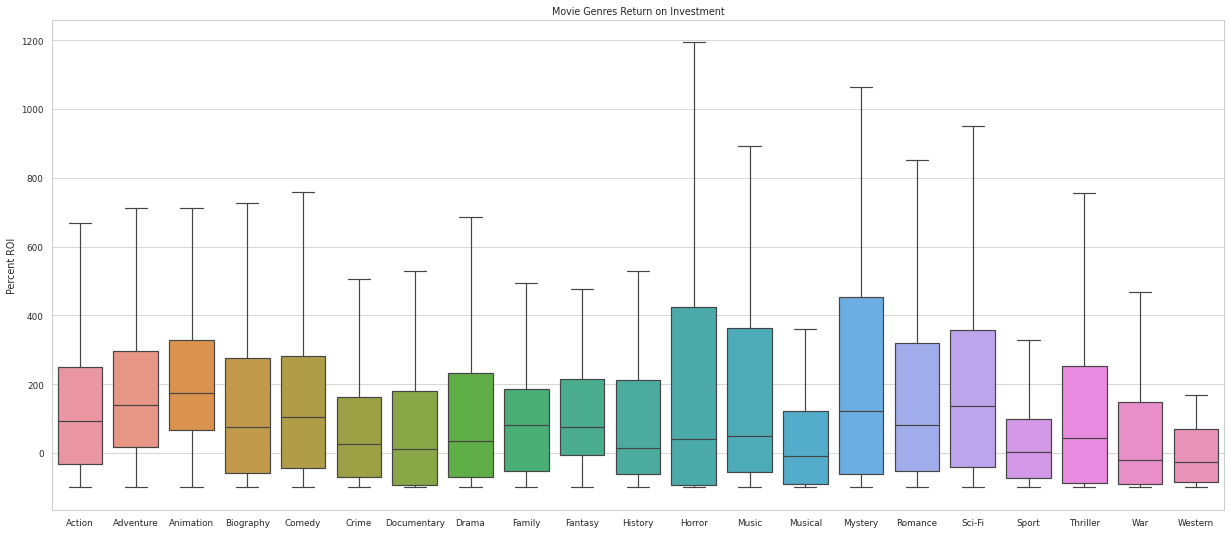

In [16]:

sns.set(rc={'figure.figsize':(21,9)})
sns.set_theme(style='whitegrid',context='paper');
genre_plot_1 = sns.boxplot(data = genre_financials,showfliers = False)
genre_plot_1.set_ylabel('Percent ROI');
genre_plot_1.set_title('Movie Genres Return on Investment');

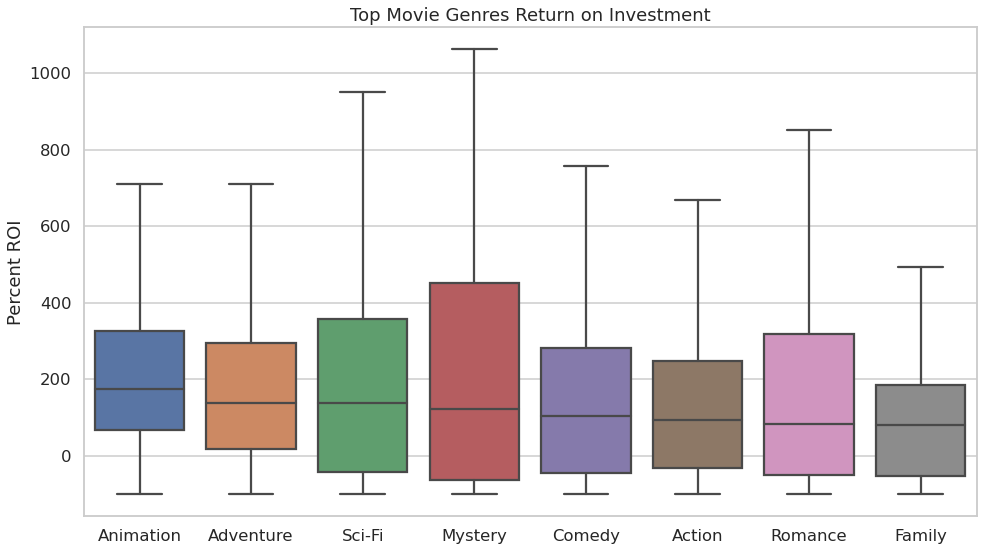

In [17]:
top_genre_financials = genre_financials[genre_financials.median().sort_values(ascending=False).index[:8]]
sns.set(rc={'figure.figsize':(16,9)})
sns.set_theme(style='whitegrid',context='talk');
genre_plot_2 = sns.boxplot(data = top_genre_financials,showfliers = False)
genre_plot_2.set_ylabel('Percent ROI');
genre_plot_2.set_title('Top Movie Genres Return on Investment');

<h3>Genre Profit Graphs</h3>

The following two boxplots show the total profit for each genre. The first shows every genre present in the dataset, and the second limits this to the 8 top-performing genres. The order of the top 8 genres was not the same as it was in the ROI plot, but I used the same order as in the ROI plot for consistency. By total profit, the top performing genres are Animation, Adventure, and Sci-Fi. 

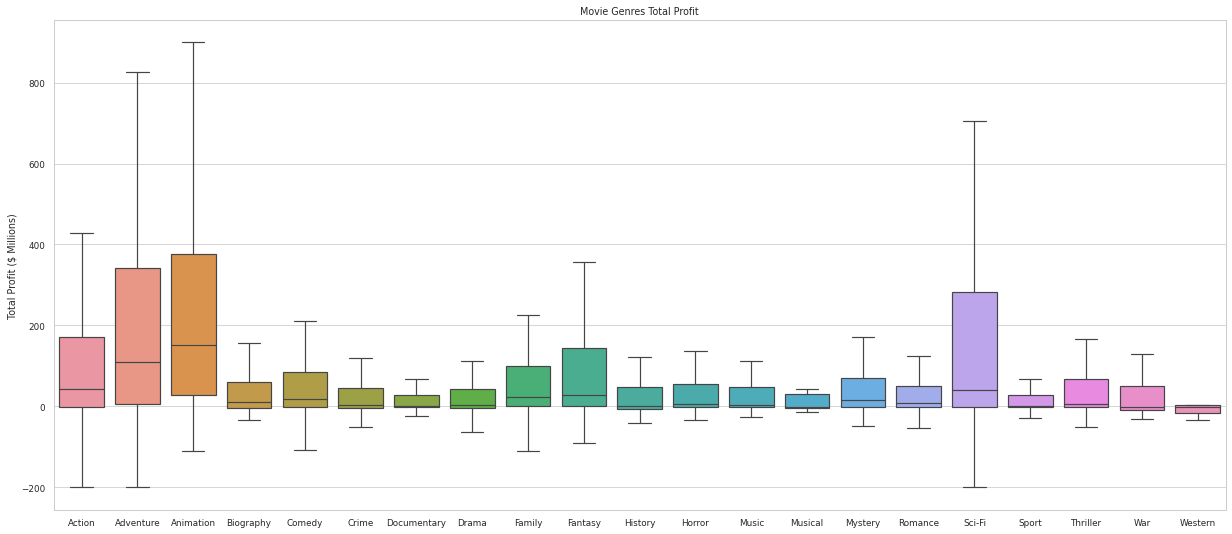

In [18]:
sns.set(rc={'figure.figsize':(21,9)})
sns.set_theme(style='whitegrid',context='paper');
genre_plot_3 = sns.boxplot(data = genre_profits/1000000,showfliers = False)
genre_plot_3.set_ylabel('Total Profit ($ Millions)');
genre_plot_3.set_title('Movie Genres Total Profit');

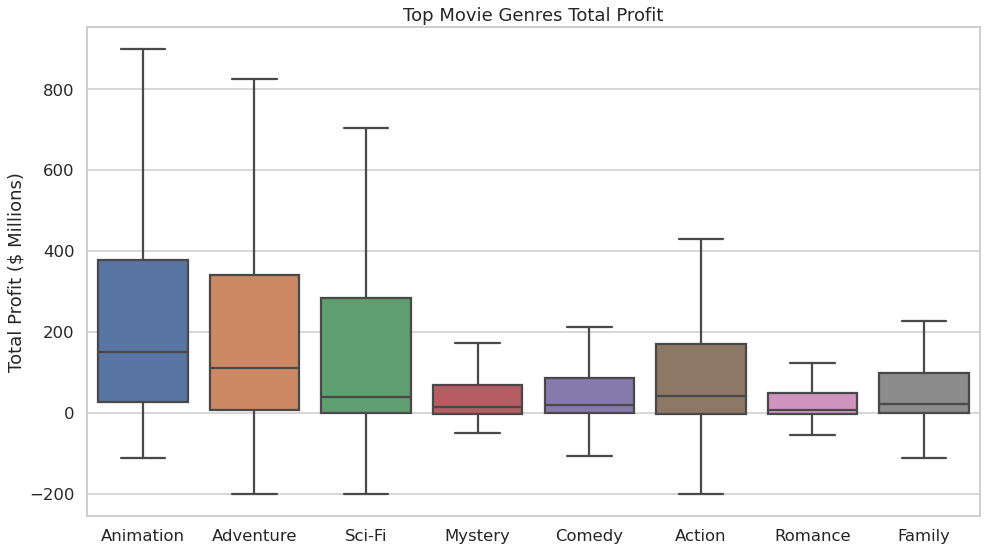

In [19]:
top_genre_profits = genre_profits[genre_financials.median().sort_values(ascending=False).index[:8]]
sns.set(rc={'figure.figsize':(16,9)})
sns.set_theme(style='whitegrid',context='talk');
genre_plot_4 = sns.boxplot(data = top_genre_profits/1000000,showfliers = False)
genre_plot_4.set_ylabel('Total Profit ($ Millions)');
genre_plot_4.set_title('Top Movie Genres Total Profit');

<h3>Season ROI Graphs</h3>
The following three graphs show the ROI broken down by the release's time of year. The first barchart shows the median ROI by season for a period of 9 years. While it isn't immediately clear which season has the best return, the summer seems to be the best performing in the most years compared to other seasons.

The second and third plots show the ROI broken down by season and month respectively for all years in the dataset combined. From these graphs, it is clear that releasing in the summer (June or July) is advantageous, and releasing in November would be acceptable as well.

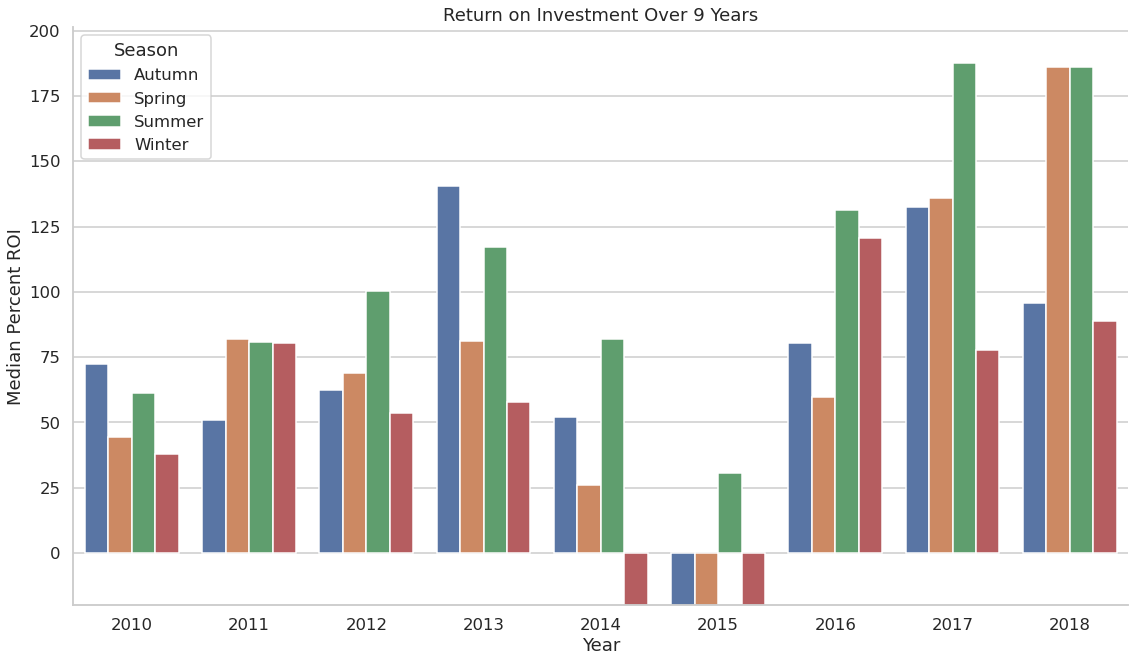

In [20]:
low_year, high_year = (2010,2019)
season_years = combined_financial[(combined_financial['year'].astype(int) >= low_year) & (combined_financial['year'].astype(int) < high_year)]

season_financial = season_years.groupby(['year','Season']).agg(median_earning = ('roi_%_worldwide','median'))
season_financial = season_financial.reset_index()
season_year_plot = sns.catplot(data = season_financial,x='year',y='median_earning',hue='Season',kind='bar',height = 9,aspect=(16/9),legend_out=False)
season_year_plot.set(ylim = (-20,None),ylabel = "Median Percent ROI",title = 'Return on Investment Over 9 Years',xlabel = 'Year');

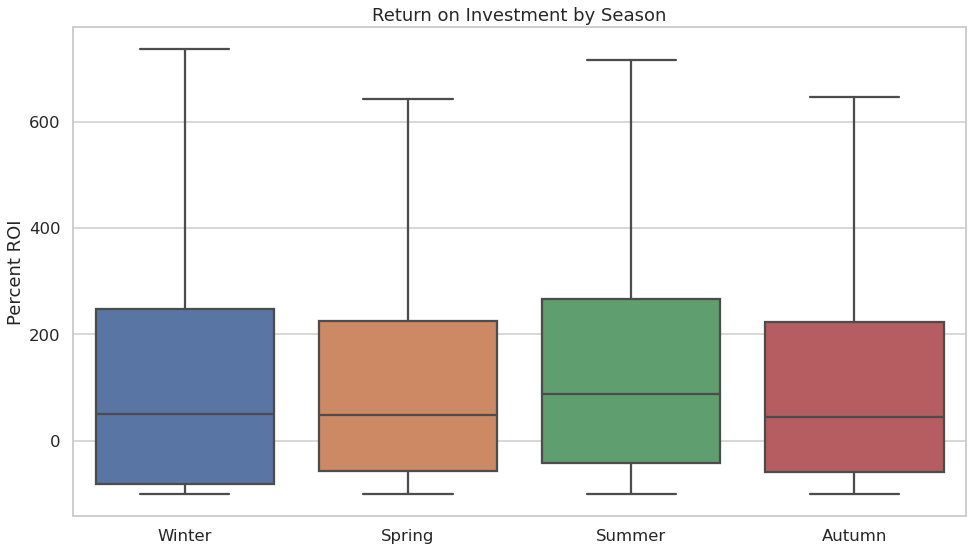

In [21]:
seasons_in_order = ['Winter','Spring','Summer','Autumn']
season_plot = sns.boxplot(data = combined_financial,x='Season',y='roi_%_worldwide',showfliers = False, order = seasons_in_order)
season_plot.set_ylabel('Percent ROI');
season_plot.set_xlabel(None);
season_plot.set_title('Return on Investment by Season');

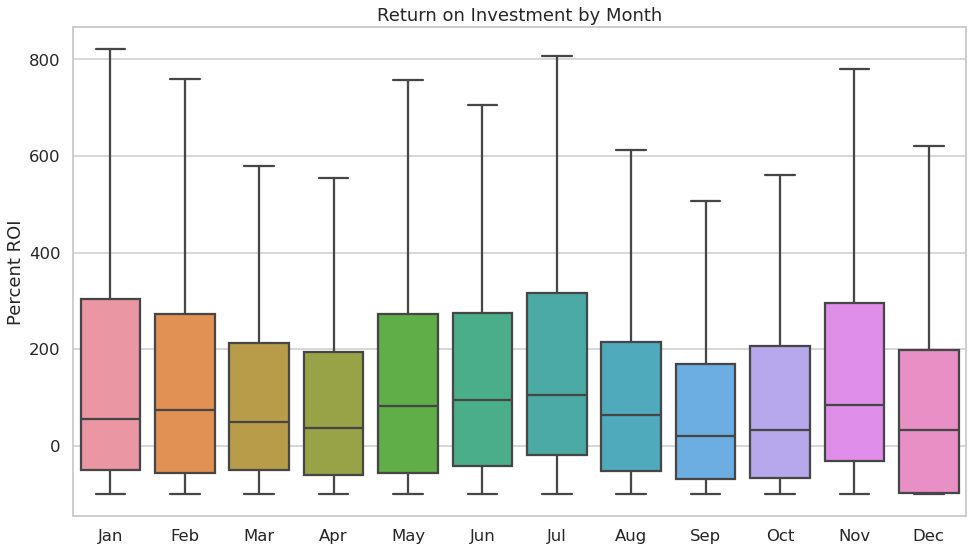

In [22]:
months_in_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_plot = sns.boxplot(data = combined_financial,x='month',y='roi_%_worldwide',showfliers = False, order = months_in_order)
month_plot.set_ylabel('Percent ROI');
month_plot.set_xlabel(None);
month_plot.set_title('Return on Investment by Month');

<h3>Season Profit Graphs</h3>
The following three graphs show the total profit broken down by the release's time of year. The first barchart shows the median total profit by season for a period of 9 years. While it isn't immediately clear which season has the best profit, the summer seems to be the best performing in the most years compared to other seasons.

The second and third plots show the total profit broken down by season and month respectively for all years in the dataset combined. The difference is more difficult to see here than in the ROI graphs, but summer (June or July) and November still seem to be the best performing.

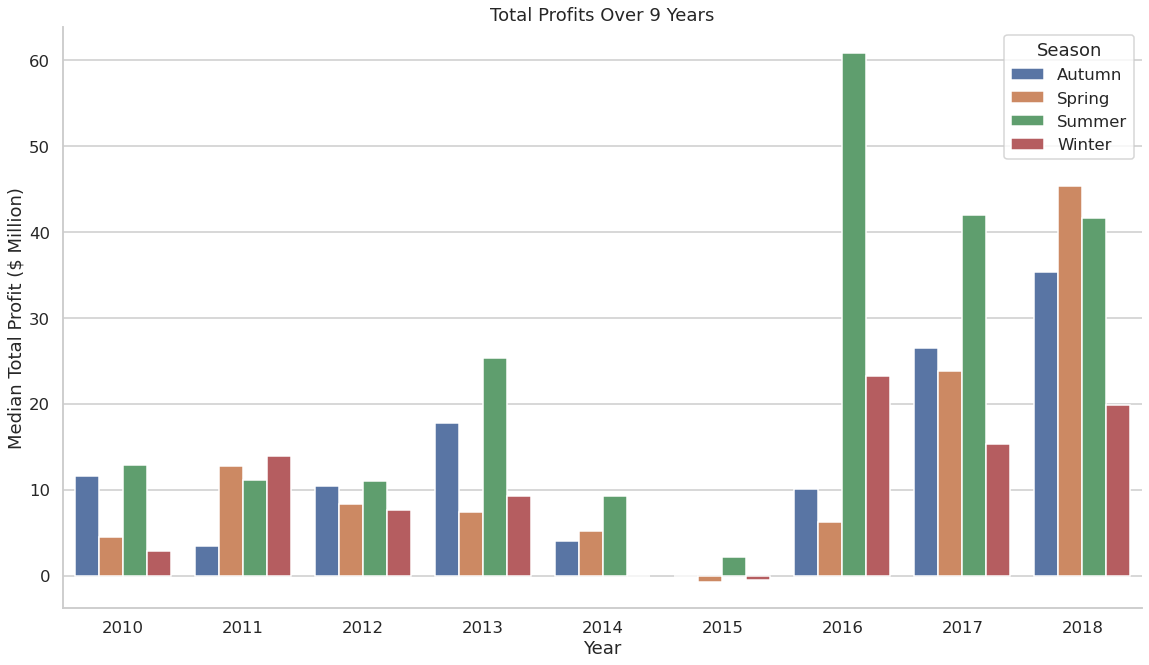

In [23]:

season_profit = season_years.groupby(['year','Season']).agg(median_earning = ('clean_profit','median'))
season_profit = season_profit.reset_index()
season_year_plot_2 = sns.catplot(data = season_profit,x='year',y=season_profit['median_earning']/1000000,hue='Season',kind='bar',height = 9,aspect=(16/9),legend_out=False)
season_year_plot_2.set(ylim = (None,None),ylabel = "Median Total Profit ($ Million)",title = 'Total Profits Over 9 Years',xlabel = 'Year');

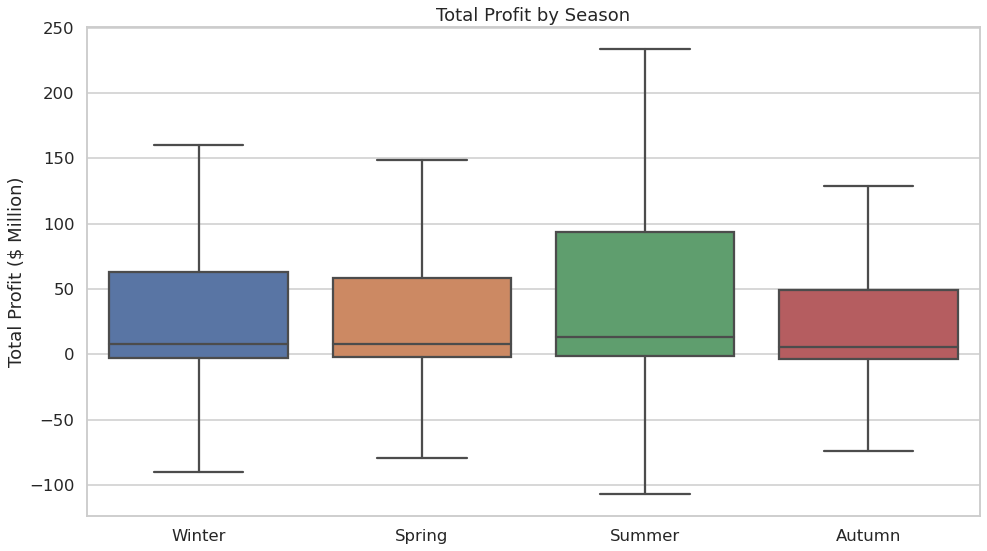

In [24]:
season_plot_2 = sns.boxplot(data = combined_financial,x='Season',y=combined_financial['clean_profit']/1000000,showfliers = False, order = seasons_in_order)
season_plot_2.set_ylabel('Total Profit ($ Million)');
season_plot_2.set_xlabel(None);
season_plot_2.set_title('Total Profit by Season');

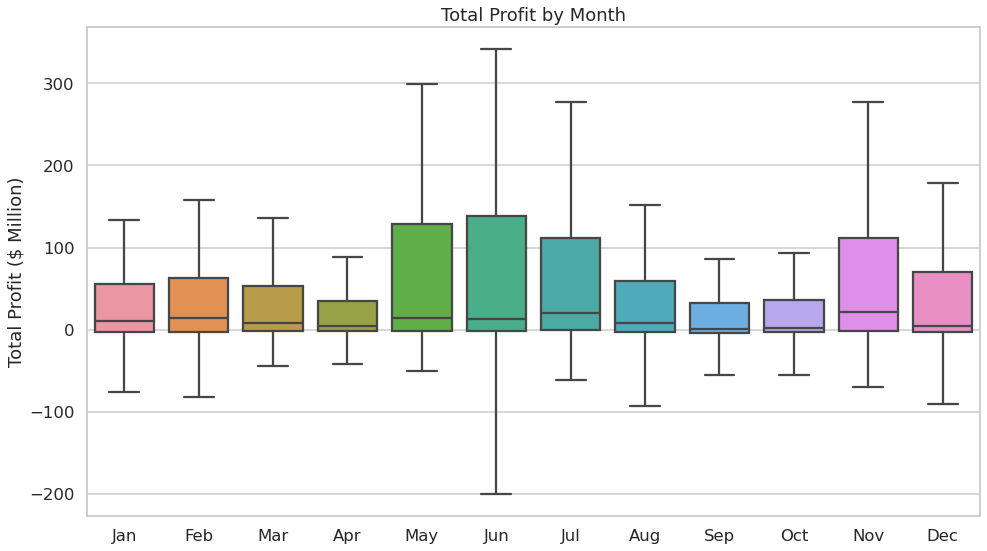

In [25]:
months_in_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month_plot_2 = sns.boxplot(data = combined_financial,x='month',y=combined_financial['clean_profit']/1000000,showfliers = False, order = months_in_order)
month_plot_2.set_ylabel('Total Profit ($ Million)');
month_plot_2.set_xlabel(None);
month_plot_2.set_title('Total Profit by Month');

<h3>Budget Binning</h3>

For the analysis on movie budget, I started by grouping the movies into $20 million bins. The following table shows the number of movies in each bin. The histogram after that shows the number of movies in the dataset at a given budget.

In [26]:
budget_bins = [*range(0,220000000,20000000),500000000]
binned_financial = combined_financial[['clean_budget','roi_%_worldwide','clean_profit']]
binned_financial['budget_bin'] = pd.cut(binned_financial['clean_budget'],budget_bins)
labels = ['0-20','20-40','40-60','60-80','80-100','100-120','120-140','140-160','160-180','180-200','200+']
binned_financial.groupby('budget_bin').count()

,clean_budget,roi_%_worldwide,clean_profit
budget_bin,,,
"(0, 20000000]",2398,2398,2398
"(20000000, 40000000]",844,844,844
"(40000000, 60000000]",393,393,393
"(60000000, 80000000]",234,234,234
"(80000000, 100000000]",147,147,147
"(100000000, 120000000]",75,75,75
"(120000000, 140000000]",72,72,72
"(140000000, 160000000]",70,70,70
"(160000000, 180000000]",51,51,51


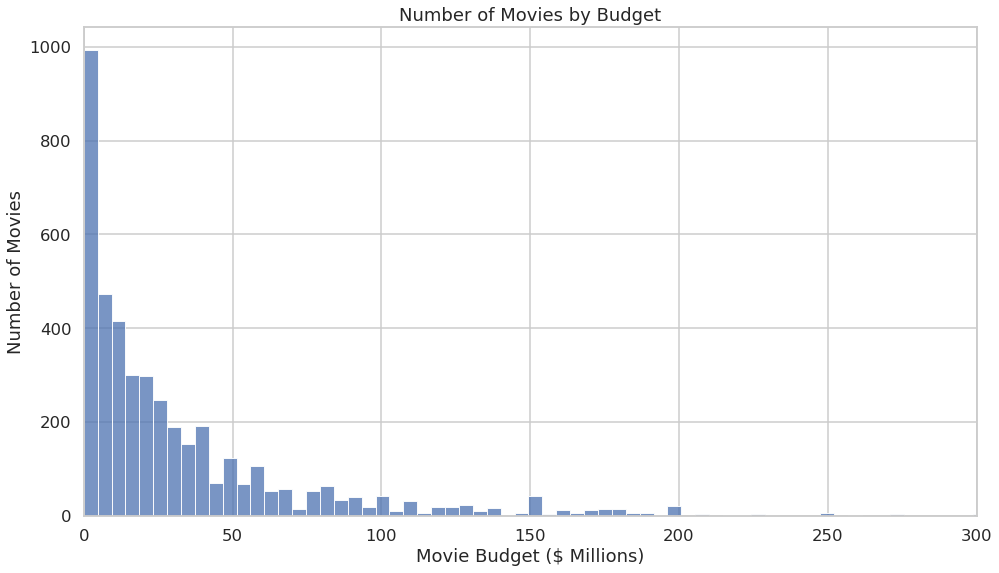

In [27]:
budget_plot = sns.histplot(data=combined_financial,x='clean_budget')
budget_plot.set(xlim = (0,300000000))
budget_plot.set_title('Number of Movies by Budget');
budget_plot.set_xlabel('Movie Budget ($ Millions)');
budget_plot.set_ylabel('Number of Movies');
budget_plot.set_xticklabels([int(x)//1000000 for x in budget_plot.get_xticks()]);

<h3>Budget Graphs</h3>

The following two boxplots show the ROI and total profit respectively for each of the budget bins. These graphs both suggest that movies with a higher budget perform better. However, as you can see from the histogram above, movies with $200 million in budget or higher are rare. This leads to me having less confidence in the $200 million + bin. I believe the sweet spot for profitability is in the $120 million to $200 million bins where the profit is nearly as high and there are more data points allowing for higher confidence.

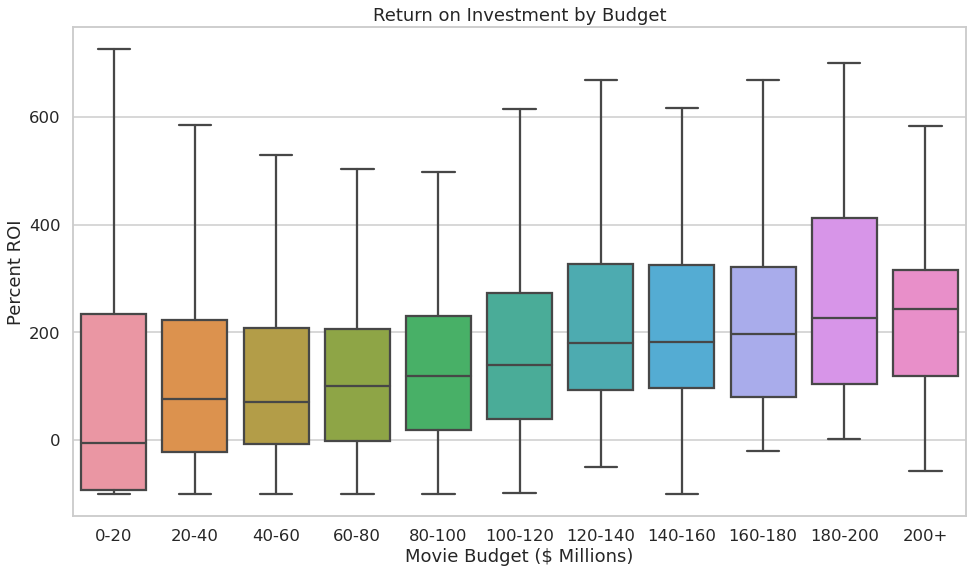

In [28]:
budget_plot_2 = sns.boxplot(data = binned_financial,x='budget_bin',y='roi_%_worldwide',showfliers = False)
budget_plot_2.set_xticklabels(labels);
budget_plot_2.set_title('Return on Investment by Budget');
budget_plot_2.set_xlabel('Movie Budget ($ Millions)');
budget_plot_2.set_ylabel('Percent ROI');


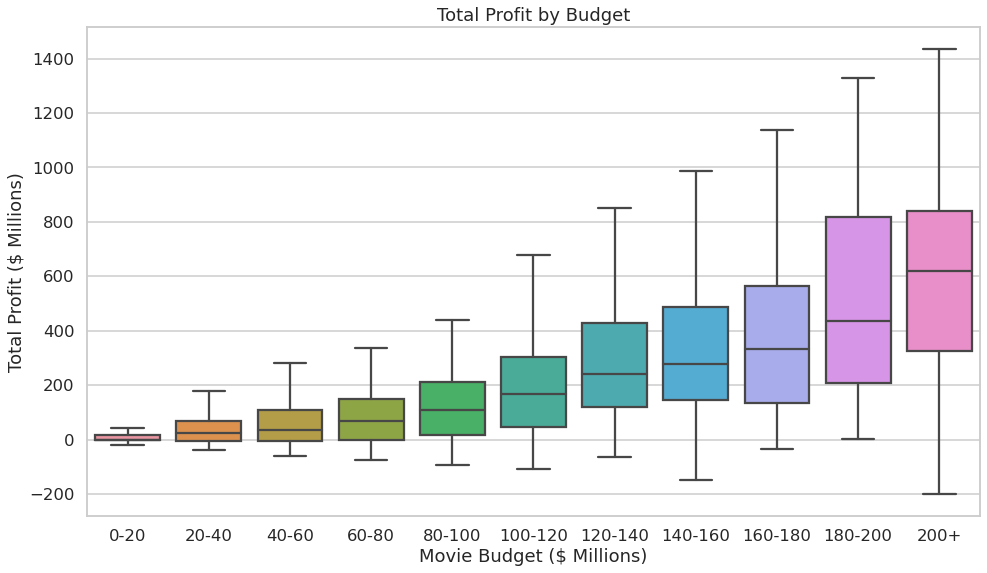

In [29]:
budget_plot_3 = sns.boxplot(data = binned_financial,x='budget_bin',y=binned_financial['clean_profit']/1000000,showfliers = False)
budget_plot_3.set_xticklabels(labels);
budget_plot_3.set_title('Total Profit by Budget');
budget_plot_3.set_xlabel('Movie Budget ($ Millions)');
budget_plot_3.set_ylabel('Total Profit ($ Millions)');

<h3>Budget Graphs Alternate Binning</h3>

The following two boxplots explore what happens when the data is divided into equal size bins rather than equal width bins. This mostly shows the same thing as the equal width bin plots, but has less resolution at the high end of budgets which makes it considerably less useful. The top bin here has a massive $330 million range of values.

In [30]:
q_binned_financial = combined_financial[['clean_budget','roi_%_worldwide','clean_profit']]
q_binned_financial['budget_bin'] = pd.qcut(binned_financial['clean_budget'],10)
q_labels_intervals = q_binned_financial['budget_bin'].unique().tolist()
q_labels = [str(math.trunc(x.left/1000000)) + ' - ' + str(math.trunc(x.right/1000000)) for x in q_labels_intervals][::-1]
q_binned_financial.groupby('budget_bin').count()

,clean_budget,roi_%_worldwide,clean_profit
budget_bin,,,
"(1099.999, 1000000.0]",446,446,446
"(1000000.0, 3500000.0]",431,431,431
"(3500000.0, 7500000.0]",446,446,446
"(7500000.0, 12000000.0]",448,448,448
"(12000000.0, 18500000.0]",412,412,412
"(18500000.0, 25000000.0]",455,455,455
"(25000000.0, 36000000.0]",420,420,420
"(36000000.0, 55000000.0]",466,466,466
"(55000000.0, 90000000.0]",428,428,428


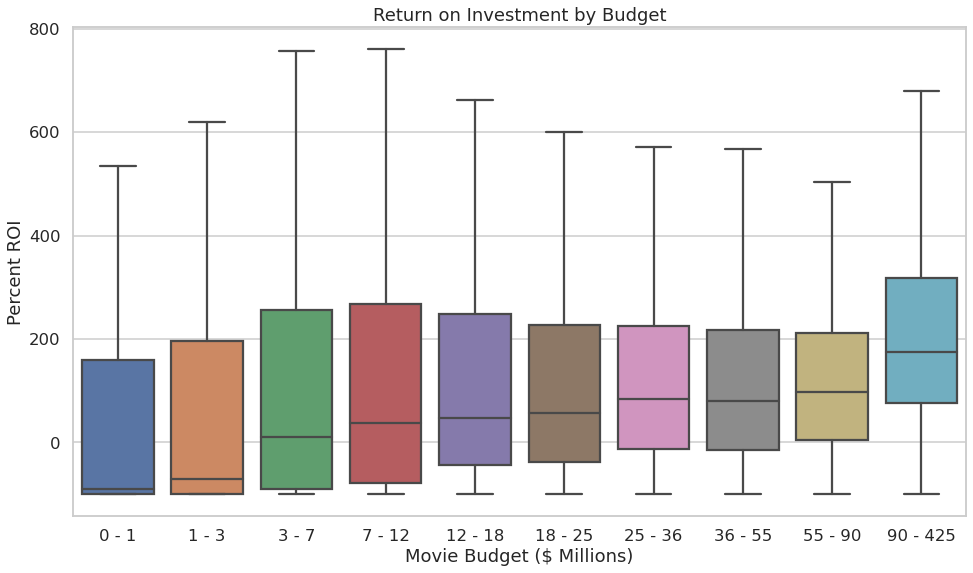

In [31]:

budget_plot_4 = sns.boxplot(data = q_binned_financial,x='budget_bin',y='roi_%_worldwide',showfliers = False)
budget_plot_4.set_xticklabels(q_labels);
budget_plot_4.set_title('Return on Investment by Budget');
budget_plot_4.set_xlabel('Movie Budget ($ Millions)');
budget_plot_4.set_ylabel('Percent ROI');

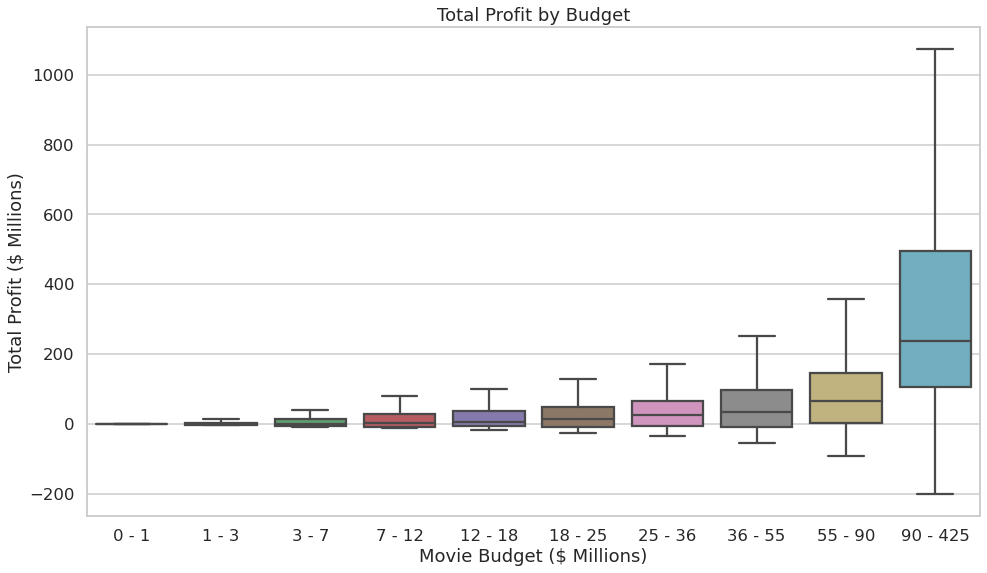

In [32]:
budget_plot_5 = sns.boxplot(data = q_binned_financial,x='budget_bin',y=q_binned_financial['clean_profit']/1000000,showfliers = False)
budget_plot_5.set_xticklabels(q_labels);
budget_plot_5.set_title('Total Profit by Budget');
budget_plot_5.set_xlabel('Movie Budget ($ Millions)');
budget_plot_5.set_ylabel('Total Profit ($ Millions)');